### Denoising Autoencoders And Where To Find Them (10 pts)

Today we're going to train deep autoencoders and deploy them to faces and search for similar images.

Our new test subjects are human faces from the [lfw dataset](http://vis-www.cs.umass.edu/lfw/).

In [1]:
import torch
import numpy as np

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim



EPOCHS = 100
BATCH_SIZE = 32
LEARNING_RATE = 1e-3

LATENT_DIMENSION = 4


device = torch.device("cpu") # or you print here you favorite gpu card
#torch.set_default_tensor_type(torch.cuda.FloatTensor) 
# uses cuda floats by default
print(device)

cpu


In [2]:
BATCH_SIZE = 32

In [3]:
import numpy as np
from lfw_dataset import fetch_lfw_dataset
from sklearn.model_selection import train_test_split
X, attr = fetch_lfw_dataset(use_raw=True, dimx=38, dimy=38)
X = X.transpose([0, 3, 1, 2]).astype('float32') / 256.0

img_shape = X.shape[1:]

X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)

In [4]:
X_train_tensor = torch.from_numpy(X_train).type(torch.DoubleTensor)
X_test_tensor = torch.Tensor(X_test).type(torch.DoubleTensor)

In [5]:
print(img_shape)

(3, 38, 38)


X shape: (13143, 3, 38, 38)
attr shape: (13143, 73)


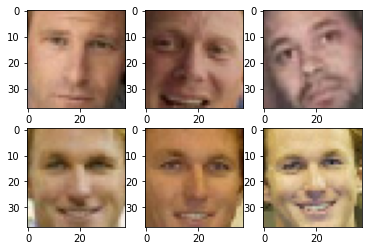

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.title('sample image')
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(X[i].transpose([1,2,0]))

print("X shape:",X.shape)
print("attr shape:",attr.shape)

### Autoencoder architecture

Let's design autoencoder as a single lasagne network, going from input image through bottleneck into the reconstructed image.

<img src="http://nghiaho.com/wp-content/uploads/2012/12/autoencoder_network1.png" width=640px>



## First step: PCA

Principial Component Analysis is a popular dimensionality reduction method. 

Under the hood, PCA attempts to decompose object-feature matrix $X$ into two smaller matrices: $W$ and $\hat W$ minimizing _mean squared error_:

$$\|(X W) \hat{W} - X\|^2_2 \to_{W, \hat{W}} \min$$
- $X \in \mathbb{R}^{n \times m}$ - object matrix (**centered**);
- $W \in \mathbb{R}^{m \times d}$ - matrix of direct transformation;
- $\hat{W} \in \mathbb{R}^{d \times m}$ - matrix of reverse transformation;
- $n$ samples, $m$ original dimensions and $d$ target dimensions;

In geometric terms, we want to find d axes along which most of variance occurs. The "natural" axes, if you wish.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/9/90/PCA_fish.png/256px-PCA_fish.png)


PCA can also be seen as a special case of an autoencoder.

* __Encoder__: X -> Dense(d units) -> code
* __Decoder__: code -> Dense(m units) -> X

Where Dense is a fully-connected layer with linear activaton:   $f(X) = W \cdot X + \vec b $


Note: the bias term in those layers is responsible for "centering" the matrix i.e. substracting mean.

In [7]:
class Reshape(nn.Module):
    """ this class corresponds to torch.reshape function and may be used as a reshape layer """
    def __init__(self, *shape):
        super().__init__()
        self.shape = shape
    def forward(self, input):
        return input.reshape(*self.shape)

In [12]:
class PCAAutoencoder(nn.Module):
    """
    Here we define a simple linear autoencoder as described above.
    We also flatten and un-flatten data to be compatible with image shapes
    """
    
    def __init__(self, code_size=50):
        super(PCAAutoencoder, self).__init__()
        self.enc = nn.Sequential(Reshape(-1, np.prod(img_shape)), nn.Linear(np.prod(img_shape), code_size))
        self.dec = nn.Sequential(nn.Linear(code_size, np.prod(img_shape)), Reshape(-1, img_shape[0], img_shape[1], img_shape[2])) 
    
    def batch_loss(self, batch, reference):
        reconstruction = self.dec(self.enc(batch))
        return torch.mean((reference - reconstruction) ** 2)
    

### Train the model

As usual, iterate minibatches of data and call train_step, then evaluate loss on validation data.

__Note to py2 users:__ you can safely drop `flush=True` from any code below.

In [13]:
from tqdm import tqdm
def train(model, dataset, dataset_test, num_epoch=32, gd=None, noise_function=None, noise_function_params=None):
    model.double()
    model.to(device)
    if gd is None:
        gd = optim.Adamax(model.parameters(), lr=0.002)
    if noise_function_params is None:
        noise_function_params = {}
    
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    losses = []
    dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True)
    scores = []

    for epoch in range(num_epoch):
        model.train(True)
        for i, (batch) in tqdm(enumerate(dataloader)):
            gd.zero_grad()
            if noise_function is not None:
                batch_noised = noise_function(batch, **noise_function_params).to(device=device)
                loss = model.batch_loss(batch_noised, batch.to(device=device))
            else:
                batch = batch.to(device=device)
                loss = model.batch_loss(batch, batch)
            (loss).backward()
            losses.append(loss.data.cpu().numpy())
            gd.step()
            gd.zero_grad()
        train_mse = np.mean(losses[-(i+1):])
        
        model.train(False)
        for i, (batch) in enumerate(dataloader_test):
            batch = batch.to(device=device)
            scores.append(model.batch_loss(batch, batch).data.cpu().numpy())
        test_mse  = np.mean(scores[-(i+1):])

        print(f"{epoch+1}, Train loss: {train_mse}, Test loss: {test_mse}")

In [18]:
def visualize(img, model):
    """Draws original, encoded and decoded images"""
    model.train(False)
    code = model.enc(img[None].to(device=device))

    reco = model.dec(code)

    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(img.cpu().numpy().transpose([1, 2, 0]).clip(0, 1))

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.cpu().detach().numpy().reshape([code.shape[-1] // 2, -1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    plt.imshow(reco[0].cpu().detach().numpy().transpose([1, 2, 0]).clip(0, 1))
    plt.show()


In [15]:
aenc = PCAAutoencoder()
train(aenc, X_train_tensor, X_test_tensor, 40)

370it [00:03, 123.33it/s]


1, Train loss: 0.10018618166020642, Test loss: 0.023931188956619446


370it [00:02, 150.94it/s]


2, Train loss: 0.023238678424325514, Test loss: 0.02322541471333263


370it [00:02, 134.62it/s]


3, Train loss: 0.022891407682223468, Test loss: 0.022999370622033756


370it [00:03, 118.98it/s]


4, Train loss: 0.022631808534794087, Test loss: 0.02263527589099097


370it [00:02, 126.61it/s]


5, Train loss: 0.022254550132367688, Test loss: 0.022297070783005586


370it [00:02, 131.63it/s]


6, Train loss: 0.021573320107753854, Test loss: 0.021201915001439125


370it [00:02, 132.19it/s]


7, Train loss: 0.020447188849219235, Test loss: 0.020135620491359744


370it [00:02, 127.57it/s]


8, Train loss: 0.018924334212906402, Test loss: 0.018415798748205016


370it [00:03, 107.92it/s]


9, Train loss: 0.01750001291451205, Test loss: 0.017536266266379514


370it [00:03, 122.43it/s]


10, Train loss: 0.016261771149768272, Test loss: 0.015783206866414195


370it [00:02, 136.45it/s]


11, Train loss: 0.014715082658764016, Test loss: 0.014231981364751503


370it [00:03, 114.85it/s]


12, Train loss: 0.01342076162401452, Test loss: 0.013196581472797326


370it [00:03, 119.04it/s]


13, Train loss: 0.01231337205054466, Test loss: 0.011817540889636541


370it [00:03, 113.21it/s]


14, Train loss: 0.011498775737928606, Test loss: 0.011114265509261808


370it [00:02, 137.36it/s]


15, Train loss: 0.01062337332719993, Test loss: 0.01056813515935045


370it [00:02, 126.73it/s]


16, Train loss: 0.010136034955780245, Test loss: 0.009681485706415447


370it [00:03, 122.72it/s]


17, Train loss: 0.00954269654108578, Test loss: 0.009281384801246541


370it [00:03, 118.81it/s]


18, Train loss: 0.00911110057497623, Test loss: 0.009059875083888412


370it [00:02, 126.12it/s]


19, Train loss: 0.008699747390572724, Test loss: 0.008414494057618087


370it [00:02, 138.25it/s]


20, Train loss: 0.008274781670725607, Test loss: 0.008384906263959956


370it [00:03, 112.01it/s]


21, Train loss: 0.008038072600379672, Test loss: 0.00794907246312436


370it [00:03, 112.38it/s]


22, Train loss: 0.0077038855997279415, Test loss: 0.007551738433027949


370it [00:03, 111.57it/s]


23, Train loss: 0.007508098498032182, Test loss: 0.007394434604669871


370it [00:03, 97.26it/s] 


24, Train loss: 0.00729693317448319, Test loss: 0.007260850469638376


370it [00:03, 105.56it/s]


25, Train loss: 0.007154434357654418, Test loss: 0.00697348241935759


370it [00:03, 117.90it/s]


26, Train loss: 0.007025979890365681, Test loss: 0.007516749939071131


370it [00:03, 115.08it/s]


27, Train loss: 0.006819579714587536, Test loss: 0.006919645122408074


370it [00:03, 117.47it/s]


28, Train loss: 0.006741974164484428, Test loss: 0.006621417690696988


370it [00:03, 112.24it/s]


29, Train loss: 0.006650989974259021, Test loss: 0.006943141984800501


370it [00:03, 110.95it/s]


30, Train loss: 0.006502080805818848, Test loss: 0.006551855384018073


370it [00:02, 128.96it/s]


31, Train loss: 0.006455453776717237, Test loss: 0.006251834597300758


370it [00:03, 114.41it/s]


32, Train loss: 0.006296326597356387, Test loss: 0.0065769910248822646


370it [00:03, 93.42it/s] 


33, Train loss: 0.006310374062871173, Test loss: 0.006223556596766983


370it [00:03, 120.05it/s]


34, Train loss: 0.006231695532736942, Test loss: 0.006320236105809428


370it [00:03, 121.43it/s]


35, Train loss: 0.00617976050389356, Test loss: 0.006186740401064663


370it [00:02, 125.02it/s]


36, Train loss: 0.006178512272189341, Test loss: 0.006231793361617655


370it [00:03, 118.24it/s]


37, Train loss: 0.006091314347569662, Test loss: 0.006092033566718969


370it [00:03, 115.03it/s]


38, Train loss: 0.006024478074466495, Test loss: 0.006179225334266662


370it [00:04, 78.34it/s]


39, Train loss: 0.00601807541411126, Test loss: 0.006063828817459379


370it [00:03, 104.94it/s]


40, Train loss: 0.0060380898759938816, Test loss: 0.005953066080275637


In [16]:
dataloader_test = DataLoader(X_test_tensor, batch_size=BATCH_SIZE, shuffle=True)
scores = []
for i, (batch) in enumerate(dataloader_test):
    batch = batch.to(device=device)
    scores.append(aenc.batch_loss(batch, batch).data.cpu().numpy())
print (np.mean(scores))

0.0059986107144841365


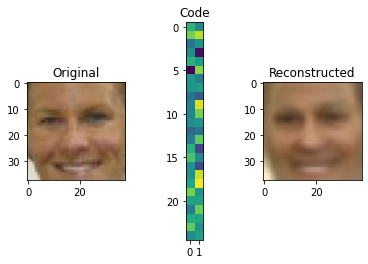

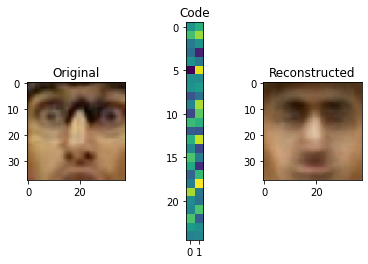

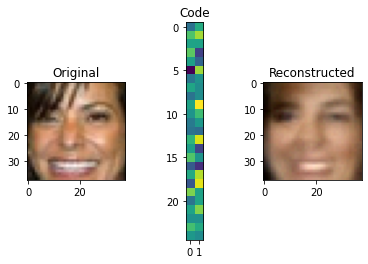

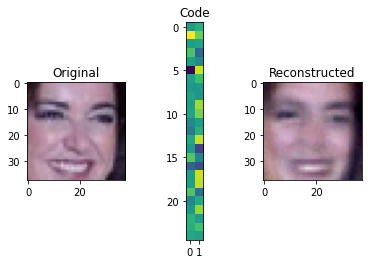

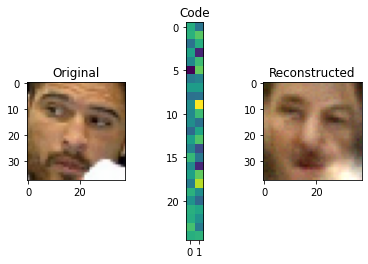

In [19]:
for i in range(5):
    img = X_test_tensor[i]
    visualize(img, aenc)


### Going deeper

PCA is neat but surely we can do better. This time we want you to build a deep autoencoder by... stacking more layers.

In particular, your encoder and decoder should be at least 3 layers deep each. You can use any nonlinearity you want and any number of hidden units in non-bottleneck layers provided you can actually afford training it.

![layers](https://pbs.twimg.com/media/CYggEo-VAAACg_n.png:small)

A few sanity checks:
* There shouldn't be any hidden layer smaller than bottleneck (encoder output).
* Don't forget to insert nonlinearities between intermediate dense layers.
* Convolutional layers are allowed but not required. To undo convolution use L.Deconv2D, pooling - L.UpSampling2D.
* Adding activation after bottleneck is allowed, but not strictly necessary.

In [22]:
class View(nn.Module):
    def __init__(self, *shape):
        super(View, self).__init__()
        self.shape = shape
    def forward(self, input):
        return input.view(*self.shape)

In [23]:
class DeepAutoencoder(nn.Module):
    def __init__(self, code_size=50):
        super(DeepAutoencoder, self).__init__()
        self.enc = nn.Sequential(
            nn.Conv2d(3, 32, 3),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Conv2d(64, 128, 3),
            View(-1, 128 * 6 * 6),
            nn.Linear(128 * 6 * 6, code_size)
        )
        self.dec = nn.Sequential(
            nn.Linear(code_size, 128 * 6 * 6),
            View(-1, 128, 6, 6),
            nn.ConvTranspose2d(128, 64, 3),
            nn.ReLU(),
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.ConvTranspose2d(64, 32, 3),
            nn.ReLU(),
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.ConvTranspose2d(32, 3, 3),
            nn.Sigmoid(),            
        )
    
    
    def batch_loss(self, batch, reference):
        a = self.enc(batch)
        reconstruction = self.dec(a)
        return torch.mean((reference - reconstruction)**2)

In [26]:
#Check autoencoder shapes along different code_sizes
get_dim = lambda layer: np.prod(layer.output_shape[1:])
for code_size in [1,8,32,128,512,1024]:
    help_tensor = next(iter(DataLoader(X_train_tensor, batch_size=BATCH_SIZE)))
    model = DeepAutoencoder(code_size).double().to(device)
    encoder_out = model.enc(help_tensor.to(device))
    decoder_out = model.dec(encoder_out)
    print("Testing code size %i" % code_size)

    assert encoder_out.shape[1:] == torch.Size([code_size]),"encoder must output a code of required size"
    assert decoder_out.shape[1:] == img_shape,   "decoder must output an image of valid shape"

    assert (sum([1 + len(list(c1level.children())) for c1level in model.dec.children()]) >= 6),  "decoder must contain at least 3 dense layers"

    del encoder_out
    del decoder_out
    torch.cuda.empty_cache()
print("All tests passed!")

Testing code size 1
Testing code size 8
Testing code size 32
Testing code size 128
Testing code size 512
Testing code size 1024
All tests passed!


__Hint:__ if you're getting "Encoder layer is smaller than bottleneck" error, use code_size when defining intermediate layers. 

For example, such layer may have code_size*2 units.

In [27]:
aenc_deep = DeepAutoencoder()
train(aenc_deep, X_train_tensor, X_test_tensor, num_epoch=50)

370it [00:37,  9.99it/s]


1, Train loss: 0.017538380769991632, Test loss: 0.011213793772356442


370it [00:43,  8.52it/s]


2, Train loss: 0.009367255134935228, Test loss: 0.008351896573478656


370it [00:45,  8.21it/s]


3, Train loss: 0.0076919871045955405, Test loss: 0.007395951792663341


370it [00:35, 10.33it/s]


4, Train loss: 0.0069403455398290475, Test loss: 0.006700841877578589


370it [00:37,  9.93it/s]


5, Train loss: 0.0063675840388393145, Test loss: 0.0062811601395396256


370it [00:31, 11.81it/s]


6, Train loss: 0.006067667417935436, Test loss: 0.00601917061499697


370it [00:35, 10.49it/s]


7, Train loss: 0.00583235642418464, Test loss: 0.0057994719519306945


370it [00:35, 10.46it/s]


8, Train loss: 0.005656736851207632, Test loss: 0.005796829615283388


370it [00:32, 11.32it/s]


9, Train loss: 0.0055382325633669014, Test loss: 0.006001388806193033


370it [00:31, 11.91it/s]


10, Train loss: 0.0054411017591312946, Test loss: 0.0055211282207676465


370it [00:30, 12.03it/s]


11, Train loss: 0.005374133338456432, Test loss: 0.005516954114741591


370it [00:30, 12.07it/s]


12, Train loss: 0.005270102972803354, Test loss: 0.005453862038365472


370it [00:30, 12.15it/s]


13, Train loss: 0.005232327632067418, Test loss: 0.005395881021335179


370it [00:30, 12.12it/s]


14, Train loss: 0.005181391109748983, Test loss: 0.005321543090409861


370it [00:30, 12.26it/s]


15, Train loss: 0.005114359740899984, Test loss: 0.005314159098289773


370it [00:30, 11.95it/s]


16, Train loss: 0.005065315613818421, Test loss: 0.0054128281501907615


370it [00:30, 12.03it/s]


17, Train loss: 0.005037156821569777, Test loss: 0.005373472808815417


370it [00:30, 12.14it/s]


18, Train loss: 0.004987739131699726, Test loss: 0.00532145115518361


370it [00:30, 12.04it/s]


19, Train loss: 0.00494687980472965, Test loss: 0.005261820735770304


370it [00:30, 12.18it/s]


20, Train loss: 0.0049202750700507005, Test loss: 0.00529150383783322


370it [00:30, 12.10it/s]


21, Train loss: 0.004896744979434952, Test loss: 0.0052478640627457935


370it [00:30, 12.25it/s]


22, Train loss: 0.004870871799722187, Test loss: 0.00534078324217305


370it [00:33, 11.15it/s]


23, Train loss: 0.004845703604724607, Test loss: 0.005194759225219177


370it [00:31, 11.77it/s]


24, Train loss: 0.004798210158638212, Test loss: 0.0052927212410491505


370it [00:32, 11.36it/s]


25, Train loss: 0.004778443068851721, Test loss: 0.005205163091396365


370it [00:32, 11.52it/s]


26, Train loss: 0.004765729005220634, Test loss: 0.0051706163815438255


370it [00:35, 10.54it/s]


27, Train loss: 0.004743710056487094, Test loss: 0.005290327928297625


370it [00:33, 11.09it/s]


28, Train loss: 0.004726214352553621, Test loss: 0.005147344261326413


370it [00:35, 10.48it/s]


29, Train loss: 0.004696631618693685, Test loss: 0.005184412596627671


370it [00:35, 10.30it/s]


30, Train loss: 0.00468567112516461, Test loss: 0.005143789633393296


370it [00:35, 10.29it/s]


31, Train loss: 0.0046716299718484325, Test loss: 0.00513468823548189


370it [00:35, 10.28it/s]


32, Train loss: 0.004647375721750427, Test loss: 0.005280588818498928


370it [00:38,  9.70it/s]


33, Train loss: 0.004644027392615996, Test loss: 0.0051464425129486985


370it [00:37,  9.89it/s]


34, Train loss: 0.004615484460705191, Test loss: 0.005207602240401786


370it [00:34, 10.70it/s]


35, Train loss: 0.004590487581191369, Test loss: 0.005162950555807281


370it [00:33, 10.97it/s]


36, Train loss: 0.004589840394021692, Test loss: 0.005103281329319938


370it [00:34, 10.77it/s]


37, Train loss: 0.004583393370785249, Test loss: 0.005123767464349536


370it [00:32, 11.36it/s]


38, Train loss: 0.004565026818898593, Test loss: 0.00524074310661727


370it [00:32, 11.23it/s]


39, Train loss: 0.004549722162222847, Test loss: 0.005094796699753561


370it [00:33, 11.19it/s]


40, Train loss: 0.004533567840704405, Test loss: 0.005156884558371406


370it [00:33, 11.17it/s]


41, Train loss: 0.00453575868031269, Test loss: 0.005102804041152278


370it [00:33, 11.11it/s]


42, Train loss: 0.004510149838786001, Test loss: 0.005139045772428215


370it [00:33, 11.06it/s]


43, Train loss: 0.004504202495789509, Test loss: 0.005068766381063423


370it [00:33, 11.00it/s]


44, Train loss: 0.00448577160097385, Test loss: 0.005146068928586804


370it [00:33, 10.89it/s]


45, Train loss: 0.004488671604735239, Test loss: 0.005085474938286705


370it [00:34, 10.87it/s]


46, Train loss: 0.0044709485075468194, Test loss: 0.005158678193954232


370it [00:34, 10.82it/s]


47, Train loss: 0.004474394814819025, Test loss: 0.005136078428037192


370it [00:34, 10.85it/s]


48, Train loss: 0.0044656912649832835, Test loss: 0.005098536365897758


370it [00:35, 10.40it/s]


49, Train loss: 0.004450607903628377, Test loss: 0.005104371894870089


370it [00:35, 10.56it/s]


50, Train loss: 0.004453847188554098, Test loss: 0.005083798061858468


Training may take long, it's okay.

Final MSE: 0.005104465258968592


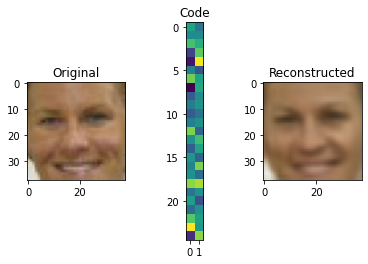

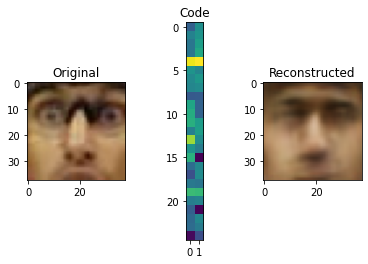

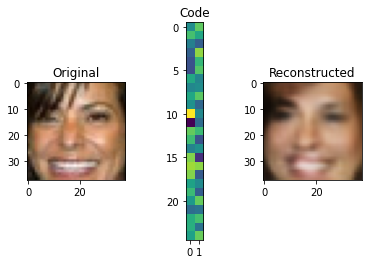

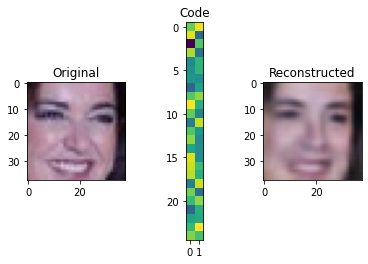

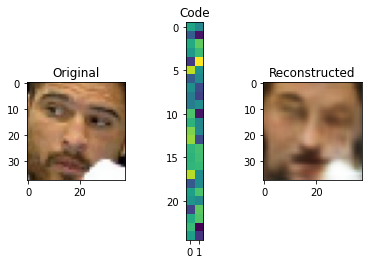

In [28]:
aenc_deep.train(False)
dataloader_test = DataLoader(X_test_tensor, batch_size=BATCH_SIZE, shuffle=True)
scores = []
for i, (batch) in enumerate(dataloader_test):
    batch = batch.to(device=device)
    scores.append(aenc_deep.batch_loss(batch, batch).data.cpu().numpy())
    encoder_out = aenc_deep.enc(batch)
reconstruction_mse  = np.mean(scores)

assert reconstruction_mse <= 0.0055, "Compression is too lossy. See tips below."
assert len(encoder_out.shape) == 2 and encoder_out.shape[1] == 50, "Make sure encoder has code_size units"
print("Final MSE:", reconstruction_mse)
for i in range(5):
    img = X_test_tensor[i]
    visualize(img,aenc_deep)

__Tips:__ If you keep getting "Compression to lossy" error, there's a few things you might try:

* Make sure it converged. Some architectures need way more than 32 epochs to converge. They may fluctuate a lot, but eventually they're going to get good enough to pass. You may train your network for as long as you want.

* Complexity. If you already have, like, 152 layers and still not passing threshold, you may wish to start from something simpler instead and go in small incremental steps.

* Architecture. You can use any combination of layers (including convolutions, normalization, etc) as long as __encoder output only stores 50 numbers per training object__. 

A cunning learner can circumvent this last limitation by using some manual encoding strategy, but he is strongly recommended to avoid that.

## Denoising AutoEncoder

Let's now make our model into a denoising autoencoder.

We'll keep your model architecture, but change the way it trains. In particular, we'll corrupt it's input data randomly before each epoch.

There are many strategies to apply noise. We'll implement two popular one: adding gaussian noise and using dropout.

In [29]:
def apply_gaussian_noise(X, sigma=0.1):
    """
    adds noise from normal distribution with standard deviation sigma
    :param X: image tensor of shape [batch,height,width,3]
    """
    
    noise = np.random.normal(0, sigma, X.shape)
        
    return X + noise
    

In [30]:
#noise tests
theoretical_std = (X[:100].std() ** 2 + 0.5 ** 2)**.5
our_std = apply_gaussian_noise(torch.from_numpy(X[:100]), sigma=0.5).std()
assert abs(theoretical_std - our_std) < 0.01, "Standard deviation does not match it's required value. Make sure you use sigma as std."
assert abs(apply_gaussian_noise(torch.from_numpy(X[:100]), sigma=0.5).mean() - torch.from_numpy(X[:100]).mean()) < 0.01, "Mean has changed. Please add zero-mean noise"

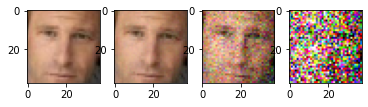

In [31]:
plt.subplot(1,4,1)
plt.imshow(X[0].transpose([1,2,0]))
plt.subplot(1,4,2)
plt.imshow(apply_gaussian_noise(torch.from_numpy(X[:1]), sigma=0.01).data.numpy()[0].transpose([1,2,0]).clip(0, 1))
plt.subplot(1,4,3)
plt.imshow(apply_gaussian_noise(torch.from_numpy(X[:1]), sigma=0.1).data.numpy()[0].transpose([1,2,0]).clip(0, 1))
plt.subplot(1,4,4)
plt.imshow(apply_gaussian_noise(torch.from_numpy(X[:1]), sigma=0.5).data.numpy()[0].transpose([1,2,0]).clip(0, 1))

In [32]:
aenc = PCAAutoencoder()
train(aenc, X_train_tensor, X_test_tensor, 50, noise_function=apply_gaussian_noise)

370it [00:04, 76.56it/s]


1, Train loss: 0.10332819459414207, Test loss: 0.023723603706682188


370it [00:04, 84.57it/s]


2, Train loss: 0.02429538181084693, Test loss: 0.023284972318739276


370it [00:04, 78.76it/s]


3, Train loss: 0.023950259191904688, Test loss: 0.023278665923584314


370it [00:05, 68.03it/s]


4, Train loss: 0.023665459152391204, Test loss: 0.022727132580869374


370it [00:05, 72.95it/s]


5, Train loss: 0.023297959417313344, Test loss: 0.02235607945194723


370it [00:05, 70.81it/s]


6, Train loss: 0.022618080812797963, Test loss: 0.02169752404916402


370it [00:05, 73.78it/s]


7, Train loss: 0.02152647419340379, Test loss: 0.020368587162267335


370it [00:04, 75.20it/s]


8, Train loss: 0.02014477519147383, Test loss: 0.01890799497574141


370it [00:04, 79.71it/s]


9, Train loss: 0.018661768465455676, Test loss: 0.01776014531724169


370it [00:04, 83.01it/s]


10, Train loss: 0.017010918766093217, Test loss: 0.015782873164177518


370it [00:04, 84.23it/s]


11, Train loss: 0.015288087148979619, Test loss: 0.014806128085041833


370it [00:04, 81.76it/s]


12, Train loss: 0.013918387448152597, Test loss: 0.012908410045724366


370it [00:04, 84.43it/s]


13, Train loss: 0.012703669441736377, Test loss: 0.012350015739648787


370it [00:04, 84.28it/s]


14, Train loss: 0.011734411451938919, Test loss: 0.011766383799081072


370it [00:04, 82.55it/s]


15, Train loss: 0.010854423222821681, Test loss: 0.010251729889534421


370it [00:04, 84.43it/s]


16, Train loss: 0.01012010322161703, Test loss: 0.009852280749464435


370it [00:04, 83.56it/s]


17, Train loss: 0.009549152467584674, Test loss: 0.00921348956568315


370it [00:04, 77.38it/s]


18, Train loss: 0.009050664598987148, Test loss: 0.008900577149160819


370it [00:04, 74.43it/s]


19, Train loss: 0.00858674485566484, Test loss: 0.008381250044284135


370it [00:04, 81.12it/s]


20, Train loss: 0.008158078608070263, Test loss: 0.007710376499090367


370it [00:04, 82.32it/s]


21, Train loss: 0.007818596562937537, Test loss: 0.00759236186213533


370it [00:04, 82.30it/s]


22, Train loss: 0.007483373556592161, Test loss: 0.007331564425083744


370it [00:04, 83.46it/s]


23, Train loss: 0.007341520449501612, Test loss: 0.0075180870893212836


370it [00:04, 83.95it/s]


24, Train loss: 0.007125788635519694, Test loss: 0.007147374642443095


370it [00:04, 80.06it/s]


25, Train loss: 0.006998386341816613, Test loss: 0.007220099600035349


370it [00:04, 78.78it/s]


26, Train loss: 0.006877258645665695, Test loss: 0.006760410081014377


370it [00:04, 77.93it/s]


27, Train loss: 0.006808159294117728, Test loss: 0.006922391394071699


370it [00:04, 80.39it/s]


28, Train loss: 0.006668526628025471, Test loss: 0.006514124522441169


370it [00:04, 75.85it/s]


29, Train loss: 0.006549085066248131, Test loss: 0.0068592627066649025


370it [00:04, 79.47it/s]


30, Train loss: 0.006503486734118191, Test loss: 0.006398877100044114


370it [00:04, 78.91it/s]


31, Train loss: 0.0064721159023660955, Test loss: 0.0064411796066612586


370it [00:04, 75.74it/s]


32, Train loss: 0.006377834526145514, Test loss: 0.006493827107422043


370it [00:04, 74.75it/s]


33, Train loss: 0.006342637158453902, Test loss: 0.006349991572993818


370it [00:04, 78.73it/s]


34, Train loss: 0.0062579316086887994, Test loss: 0.006336721970603027


370it [00:04, 77.72it/s]


35, Train loss: 0.006248036148327314, Test loss: 0.006680724953073559


370it [00:04, 82.23it/s]


36, Train loss: 0.006182398614490217, Test loss: 0.006151280239624229


370it [00:04, 74.17it/s]


37, Train loss: 0.006166893099715457, Test loss: 0.006078251524450594


370it [00:04, 81.75it/s]


38, Train loss: 0.00611235813565213, Test loss: 0.006031637500364522


370it [00:04, 80.82it/s]


39, Train loss: 0.006049470144013647, Test loss: 0.005904677657489608


370it [00:04, 81.24it/s]


40, Train loss: 0.0060652825412017206, Test loss: 0.006040788457544449


370it [00:04, 81.00it/s]


41, Train loss: 0.006075595649564603, Test loss: 0.0061573361750105705


370it [00:04, 82.53it/s]


42, Train loss: 0.006080154128124317, Test loss: 0.006475825568040042


370it [00:04, 80.95it/s]


43, Train loss: 0.006042182886031731, Test loss: 0.005935853550189408


370it [00:04, 81.81it/s]


44, Train loss: 0.006001737280380508, Test loss: 0.0060167236135489615


370it [00:04, 82.56it/s]


45, Train loss: 0.006001535053770258, Test loss: 0.005910615445324357


370it [00:04, 80.88it/s]


46, Train loss: 0.005983270323737986, Test loss: 0.005914728312866581


370it [00:04, 77.69it/s]


47, Train loss: 0.005975389926458203, Test loss: 0.005995811022805878


370it [00:04, 76.78it/s]


48, Train loss: 0.005971308224521644, Test loss: 0.006231064617755282


370it [00:04, 82.63it/s]


49, Train loss: 0.005944041809650329, Test loss: 0.006086386064457239


370it [00:04, 79.09it/s]


50, Train loss: 0.005969492571053139, Test loss: 0.0060104183419002425


__Note:__ if it hasn't yet converged, increase the number of iterations.

__Bonus:__ replace gaussian noise with masking random rectangles on image.

Final MSE: 0.006235893985034794


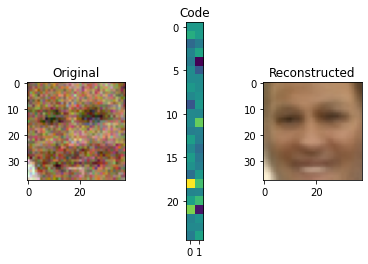

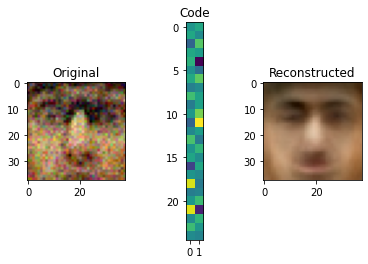

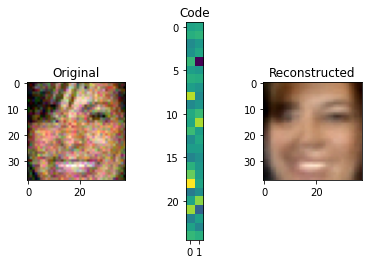

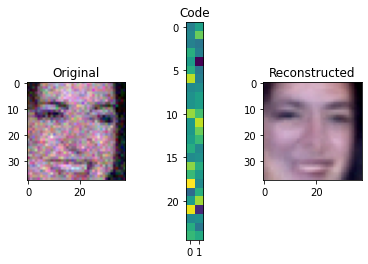

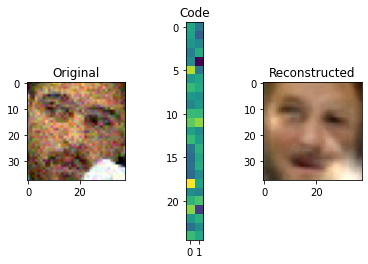

In [34]:
dataloader_test = DataLoader(X_test_tensor, batch_size=BATCH_SIZE, shuffle=True)
scores = []
for i, (batch) in enumerate(dataloader_test):
    batch_noised = apply_gaussian_noise(batch).to(device=device)
    scores.append(aenc.batch_loss(batch_noised, batch.to(device = device)).data.cpu().numpy())
    encoder_out = aenc.enc(batch_noised)
reconstruction_mse  = np.mean(scores)

print("Final MSE:", reconstruction_mse)
for i in range(5):
    img = apply_gaussian_noise(X_test_tensor[i])
    visualize(img,aenc)

### Image retrieval with autoencoders

So we've just trained a network that converts image into itself imperfectly. This task is not that useful in and of itself, but it has a number of awesome side-effects. Let's see it in action.

First thing we can do is image retrieval aka image search. We we give it an image and find similar images in latent space. 

To speed up retrieval process, we shall use Locality-Sensitive Hashing on top of encoded vectors. We'll use scikit-learn's implementation for simplicity. In practical scenario, you may want to use [specialized libraries](https://erikbern.com/2015/07/04/benchmark-of-approximate-nearest-neighbor-libraries.html) for better performance and customization.

In [36]:
#encodes batch of images into a codes


codes = aenc.enc(X_train_tensor.to(device))


In [37]:
assert codes.shape[0] == X_train_tensor.shape[0]

In [1]:
pip list | grep scikit

scikit-image                0.19.3
scikit-learn                0.20.0
Note: you may need to restart the kernel to use updated packages.


In [2]:
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes.detach().cpu().numpy())

TypeError: an integer is required (got type bytes)

In [173]:
images = torch.from_numpy(X_train).type(torch.DoubleTensor)

In [174]:
def get_similar(image, n_neighbors=5):
    assert len(image.shape) == 3, "image must be [batch, 3, height, width]"

    code = aenc.enc(image.cuda(device)).detach().cpu().numpy()
    
    (distances,),(idx,) = lshf.kneighbors(code,n_neighbors=n_neighbors)
    
    return distances,images[idx]

In [184]:
def show_similar(image):
    distances, neighbors = get_similar(image,n_neighbors=11)
    
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

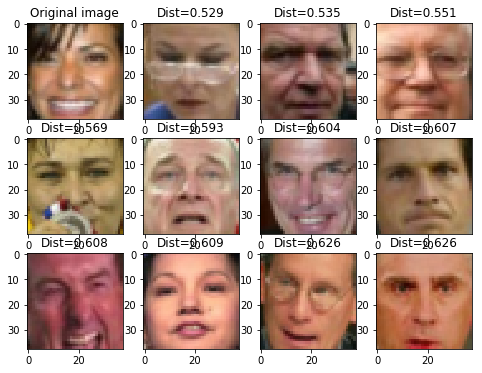

In [185]:
#smiles
show_similar(X_test_tensor[2])

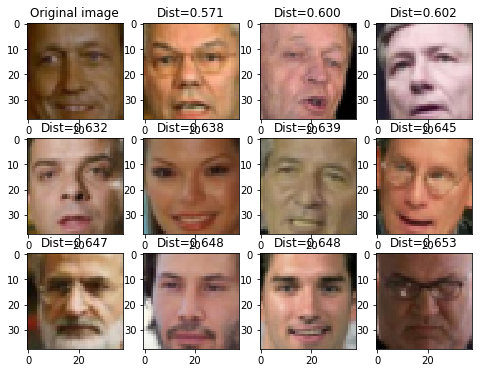

In [186]:
#ethnicity
show_similar(X_test_tensor[500])

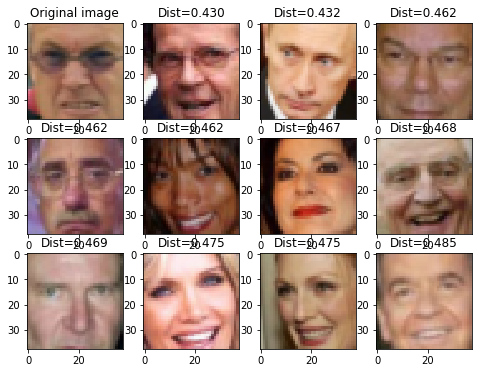

In [187]:
#glasses
show_similar(X_test_tensor[66])

## Bonus: cheap image morphing


In [43]:
X_train_noise = apply_gaussian_noise(X_train)
X_test_noise = apply_gaussian_noise(X_test)

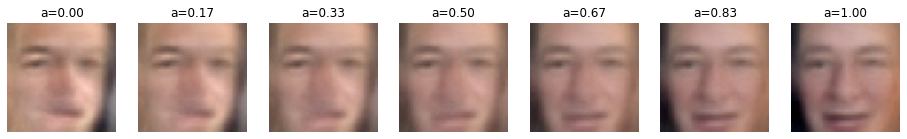

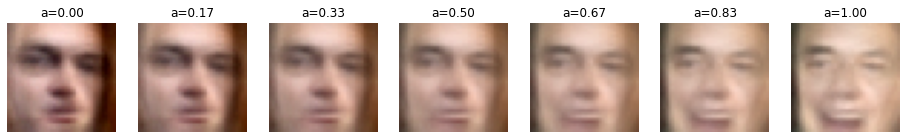

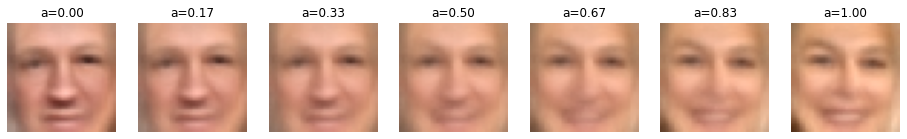

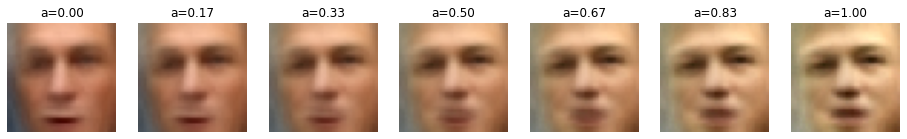

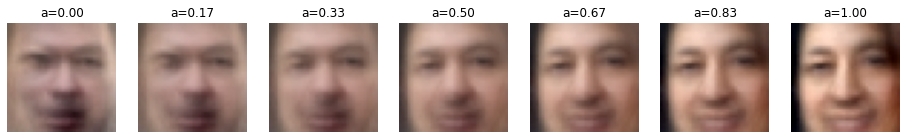

In [45]:
for _ in range(5):
    idx1, idx2 = np.random.randint(0, X_test_noise.shape[0], 2)
    image1,image2 = X_test_tensor[idx1], X_test_tensor[idx2]

    code1, code2 = aenc.enc(image1.cpu()), aenc.enc(image2.cpu())

    plt.figure(figsize=[16,4])
    for i,a in enumerate(np.linspace(0,1,num=7)):

        output_code = code1 * (1-a) + code2 * a

        output_image = aenc.dec(output_code[None])[0]
        plt.subplot(1,7,i+1)
        plt.axis("off")
        plt.imshow(output_image.cpu().detach().numpy().transpose([1,2,0]).clip(0,1))
        plt.title("a=%.2f"%a)
        
    plt.show()

Of course there's a lot more you can do with autoencoders.
If you want to generate images from scratch, however, you're better off using generative adversarial networks.